## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Functions

In [3]:
"""Functions for downstream work with outputs of remove-background."""

# to read cellbender outputs<br>
# https://github.com/broadinstitute/CellBender/issues/57

import tables
import numpy as np
import scipy.sparse as sp
from typing import Dict


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    try:
        import anndata
    except ImportError:
        raise ImportError('The anndata package must be installed to use the '
                          'function anndata_from_h5()')

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    if analyzed_barcodes_only:
        if 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the count matrix.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)})
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # Add other information to the adata object in the appropriate slot.
    for key, value in d.items():
        try:
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == X.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == X.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass

    return adata

In [4]:
# from https://github.com/Teichlab/mapcloud/blob/master/scripts/starsolo/postprocess.py

from statsmodels.stats.multitest import multipletests
# from emptydrops.matrix import CountMatrix
# from emptydrops import find_nonambient_barcodes
import scrublet as scr
import scanpy as sc
import pandas as pd
import numpy as np
import scipy

#some functions that Ni uses in scanpy scripts to run scrublet
#which in turn are inspired by my original notebook on the matter
#(extracted from scanpy_scripts 0.2.10 to get around scanpy version incompatibility)
def test_outlier(x, upper_mad_only=True):
	med = np.median(x)
	if upper_mad_only:
		mad = np.median(x[x>med] - med) * 1.4826
	else:
		mad = np.median(np.abs(x - med)) * 1.4826
	pvals = 1 - scipy.stats.norm.cdf(x, loc=med, scale=mad)
	bh_pvals = multipletests(pvals, method='fdr_bh')[1]
	return pvals, bh_pvals

def run_scrublet(adata, resolution_function=None):
	old_verbosity = sc.settings.verbosity
	sc.settings.verbosity = 1
	if resolution_function is None:
		resolution_function = lambda x: np.maximum(np.maximum(np.log10(x)-1, 0)**2, 0.1)
	scrub = scr.Scrublet(adata.X)
	#this has the potential to brick for poor quality data
	#if so, abort it and everything downstream
	try:
		ds, pd = scrub.scrub_doublets(verbose=False)
	except:
		return
	adata.obs['scrublet_score'] = ds

	adata_copy = adata.copy()
	sc.pp.filter_genes(adata_copy, min_cells=3)
	sc.pp.normalize_total(adata_copy, target_sum=1e4)
	sc.pp.log1p(adata_copy)
	sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
	sc.pp.scale(adata_copy, zero_center=False)
	sc.pp.pca(adata_copy, svd_solver='arpack', zero_center=False)
	sc.pp.neighbors(adata_copy, n_pcs=30)
	sc.tl.umap(adata_copy)
	sc.tl.leiden(adata_copy, resolution=1)
	for clst in np.unique(adata_copy.obs['leiden']):
		clst_size = sum(adata_copy.obs['leiden'] == clst)
		sc.tl.leiden(adata_copy, restrict_to=('leiden', [clst]), resolution=resolution_function(clst_size), key_added='leiden_R')
		adata_copy.obs['leiden'] = adata_copy.obs['leiden_R']
	clst_meds = []
	for clst in np.unique(adata_copy.obs['leiden']):
		k = adata_copy.obs['leiden'] == clst
		clst_med = np.median(adata_copy.obs.loc[k, 'scrublet_score'])
		adata_copy.obs.loc[k, 'cluster_scrublet_score'] = clst_med
		clst_meds.append(clst_med)
	clst_meds = np.array(clst_meds)
	pvals, bh_pvals = test_outlier(clst_meds)
	for i, clst in enumerate(np.unique(adata_copy.obs['leiden'])):
		k = adata_copy.obs['leiden'] == clst
		adata_copy.obs.loc[k, 'pval'] = pvals[i]
		adata_copy.obs.loc[k, 'bh_pval'] = bh_pvals[i]
	sc.settings.verbosity = old_verbosity
	#need to also export the clustering, for soupx purposes
	adata.obs['scrublet_leiden'] = adata_copy.obs['leiden']
	adata.obs['scrublet_score'] = adata_copy.obs['scrublet_score']
	adata.obs['cluster_scrublet_score'] = adata_copy.obs['cluster_scrublet_score']
	adata.obs['doublet_pval'] = adata_copy.obs['pval']
	adata.obs['doublet_bh_pval'] = adata_copy.obs['bh_pval']
	del adata_copy

## Create anndata object

In [5]:
# read in metadata
metadata = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20221126.csv', sep = ',', index_col = None)
metadata = metadata[metadata['Publication']=='Foetal']

# select healthy data
metadata = metadata[metadata['status']=='Healthy']


print(metadata['modality'].value_counts())

Multiome-ATAC    30
Multiome-RNA     30
Visium           23
scRNA            20
Name: modality, dtype: int64


In [6]:
metadata['region'].value_counts()

Heart                                          57
Apex                                            8
Left ventricle                                  7
Base                                            6
Outflow Tract                                   5
Aorta + Pulmonary artery + Ductos Arterious     4
Pericardium                                     4
Pulmonary artery  + main bronchus               4
Aorta                                           4
Atrial septum                                   2
Right ventricle + PAD                           2
Name: region, dtype: int64

In [7]:
# select modality
metadata = metadata[metadata['modality']=='scRNA']

In [8]:
pd.crosstab(metadata['kit_10x'], metadata['facility'])

facility,CSCI,Sanger
kit_10x,,
3prime-v3,12,0
5prime-v2,0,8


In [9]:
########### editted: put id to var_names ###########

# read in
adatas=[]
for i in range(len(metadata)):
    print(metadata.iloc[i]['sangerID'])
    
    path=metadata.iloc[i]['CellBender_out']
    adatas.append(anndata_from_h5(path + '/' + path.split('/')[-1] + '_cellbender_out_filtered.h5', analyzed_barcodes_only=False))
    del path
    
    # replace var_names with ensembleID
    adatas[i].var.reset_index(inplace=True)
    if 'id' in adatas[i].var.columns:
        adatas[i].var.set_index('id',inplace=True)
    else:
        adatas[i].var.set_index('genes',inplace=True)
    
    # modify barcodes
    adatas[i].obs.index = metadata.iloc[i]['sangerID'] + '_' + adatas[i].obs.index 
    
    # add metadata
    for col in ['sangerID','combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age',
                'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x','flushed']:
        adatas[i].obs[col] = metadata.iloc[i][col]


# concatenate
adata = adatas[0].concatenate(adatas[1:], index_unique = None, batch_key=None)
adata.shape

BHF_F_Hea10402917
BHF_F_Hea10402918
BHF_F_Hea11192323
BHF_F_Hea11192324
BHF_F_Hea11192325
BHF_F_Hea11192326
BHF_F_Hea11192327
BHF_F_Hea11192328
Sinha_A1
Sinha_B1
Sinha_C8
Sinha_D8
Sinha_E2
Sinha_E8
Sinha_F2
Sinha_F4
Sinha_F7
Sinha_F8
Sinha_G4
Sinha_G7


(205457, 36601)

In [10]:
for i in range(len(adatas)):
    print(adatas[i].var.columns)

Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambient_expression', 'feature_type'], dtype='object')
Index(['gene_name', 'ambi

In [11]:
adata.obs['sangerID'].value_counts()

Sinha_F2             24275
Sinha_E2             24227
BHF_F_Hea11192328    21714
Sinha_E8             17219
BHF_F_Hea11192324    16688
BHF_F_Hea11192326    14117
BHF_F_Hea11192325    10676
Sinha_F4             10652
BHF_F_Hea11192327     9130
BHF_F_Hea10402918     8010
Sinha_F7              6973
Sinha_D8              6714
Sinha_A1              6640
Sinha_B1              5988
BHF_F_Hea11192323     4893
Sinha_C8              4587
BHF_F_Hea10402917     3752
Sinha_G4              3389
Sinha_F8              3203
Sinha_G7              2610
Name: sangerID, dtype: int64

## Run scrublet

In [12]:
adata.obs['sangerID'].unique()

array(['BHF_F_Hea10402917', 'BHF_F_Hea10402918', 'BHF_F_Hea11192323',
       'BHF_F_Hea11192324', 'BHF_F_Hea11192325', 'BHF_F_Hea11192326',
       'BHF_F_Hea11192327', 'BHF_F_Hea11192328', 'Sinha_A1', 'Sinha_B1',
       'Sinha_C8', 'Sinha_D8', 'Sinha_E2', 'Sinha_E8', 'Sinha_F2',
       'Sinha_F4', 'Sinha_F7', 'Sinha_F8', 'Sinha_G4', 'Sinha_G7'],
      dtype=object)

In [13]:
%%time

# per rxn
for i,ID in enumerate(adata.obs['sangerID'].unique()):
    print(ID)
    
    ad = adata[adata.obs['sangerID'] == ID].copy()
    run_scrublet(ad)
    if i==0:
        meta = ad.obs
    else:
        meta = pd.concat([meta, ad.obs])
    del ad

BHF_F_Hea10402917


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea10402918


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192323


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192324


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192325


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192326


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192327


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


BHF_F_Hea11192328


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_A1


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_B1


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_C8


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_D8


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_E2


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_E8


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_F2


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_F4


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_F7


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_F8


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_G4


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


Sinha_G7


/opt/conda/envs/teichlab/lib/python3.8/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in true_divide
  w.setdiag(float(target_total) / tots_use)


CPU times: user 35min 4s, sys: 17min 31s, total: 52min 36s
Wall time: 15min 3s


In [14]:
meta_scrub = meta[['scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval']].copy()
meta_scrub.shape

(205457, 5)

In [15]:
if meta_scrub.reindex(adata.obs.index).index.equals(adata.obs.index):
    adata.obs = pd.concat([adata.obs, meta_scrub.reindex(adata.obs.index)], axis=1)
else:
    raise Exception('Different barcodes in meta and adata')

In [16]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,sangerID,combinedID,donor,donor_type,region,region_finest,age,...,facility,cell_or_nuclei,modality,kit_10x,flushed,scrublet_score,scrublet_leiden,cluster_scrublet_score,doublet_pval,doublet_bh_pval
barcode,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea10402917_TGGCTGGGTTGTGGAG-1,5.218614,0.999939,123665.210938,BHF_F_Hea10402917,na,C86,na,Heart,Heart,GA-12w5d,...,Sanger,Cell,scRNA,5prime-v2,na,0.141153,"23,0",0.141153,4.764553e-02,0.459779
BHF_F_Hea10402917_AGCATACTCCGAATGT-1,3.561900,0.999994,13579.498047,BHF_F_Hea10402917,na,C86,na,Heart,Heart,GA-12w5d,...,Sanger,Cell,scRNA,5prime-v2,na,0.155650,"8,3",0.144651,3.929223e-02,0.446082
BHF_F_Hea10402917_ATGTGTGTCGAACGGA-1,3.109560,0.999991,10201.502930,BHF_F_Hea10402917,na,C86,na,Heart,Heart,GA-12w5d,...,Sanger,Cell,scRNA,5prime-v2,na,0.141153,"5,3",0.102894,2.499997e-01,0.950876
BHF_F_Hea10402917_CAGGTGCAGGCTATCT-1,3.181446,0.999989,10217.305664,BHF_F_Hea10402917,na,C86,na,Heart,Heart,GA-12w5d,...,Sanger,Cell,scRNA,5prime-v2,na,0.122744,"8,4",0.107438,2.140326e-01,0.950876
BHF_F_Hea10402917_TACAGTGTCCAGTATG-1,3.101654,0.999993,9392.824219,BHF_F_Hea10402917,na,C86,na,Heart,Heart,GA-12w5d,...,Sanger,Cell,scRNA,5prime-v2,na,0.134615,"11,0",0.134615,6.702337e-02,0.497520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sinha_G7_GAAACCTGTACTTGTG-1,0.394641,0.792554,19703.033203,Sinha_G7,na,BRC2263,na,Apex,Apex,9w3d,...,CSCI,Cell,scRNA,3prime-v3,na,0.304721,"3,10",0.182381,7.967981e-08,0.000005
Sinha_G7_CACCAAAAGTTGCCTA-1,0.327808,0.932766,19300.431641,Sinha_G7,na,BRC2263,na,Apex,Apex,9w3d,...,CSCI,Cell,scRNA,3prime-v3,na,0.142857,"3,10",0.182381,7.967981e-08,0.000005
Sinha_G7_TCATTACAGAGACAAG-1,0.245769,0.888818,23598.025391,Sinha_G7,na,BRC2263,na,Apex,Apex,9w3d,...,CSCI,Cell,scRNA,3prime-v3,na,0.039443,"8,5",0.089528,9.890429e-02,0.542951


## Save

In [17]:
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_foetal_prefilter.h5ad')

... storing 'sangerID' as categorical
... storing 'combinedID' as categorical
... storing 'donor' as categorical
... storing 'donor_type' as categorical
... storing 'region' as categorical
... storing 'region_finest' as categorical
... storing 'age' as categorical
... storing 'gender' as categorical
... storing 'facility' as categorical
... storing 'cell_or_nuclei' as categorical
... storing 'modality' as categorical
... storing 'kit_10x' as categorical
... storing 'flushed' as categorical
... storing 'scrublet_leiden' as categorical
... storing 'gene_name' as categorical
... storing 'feature_type' as categorical


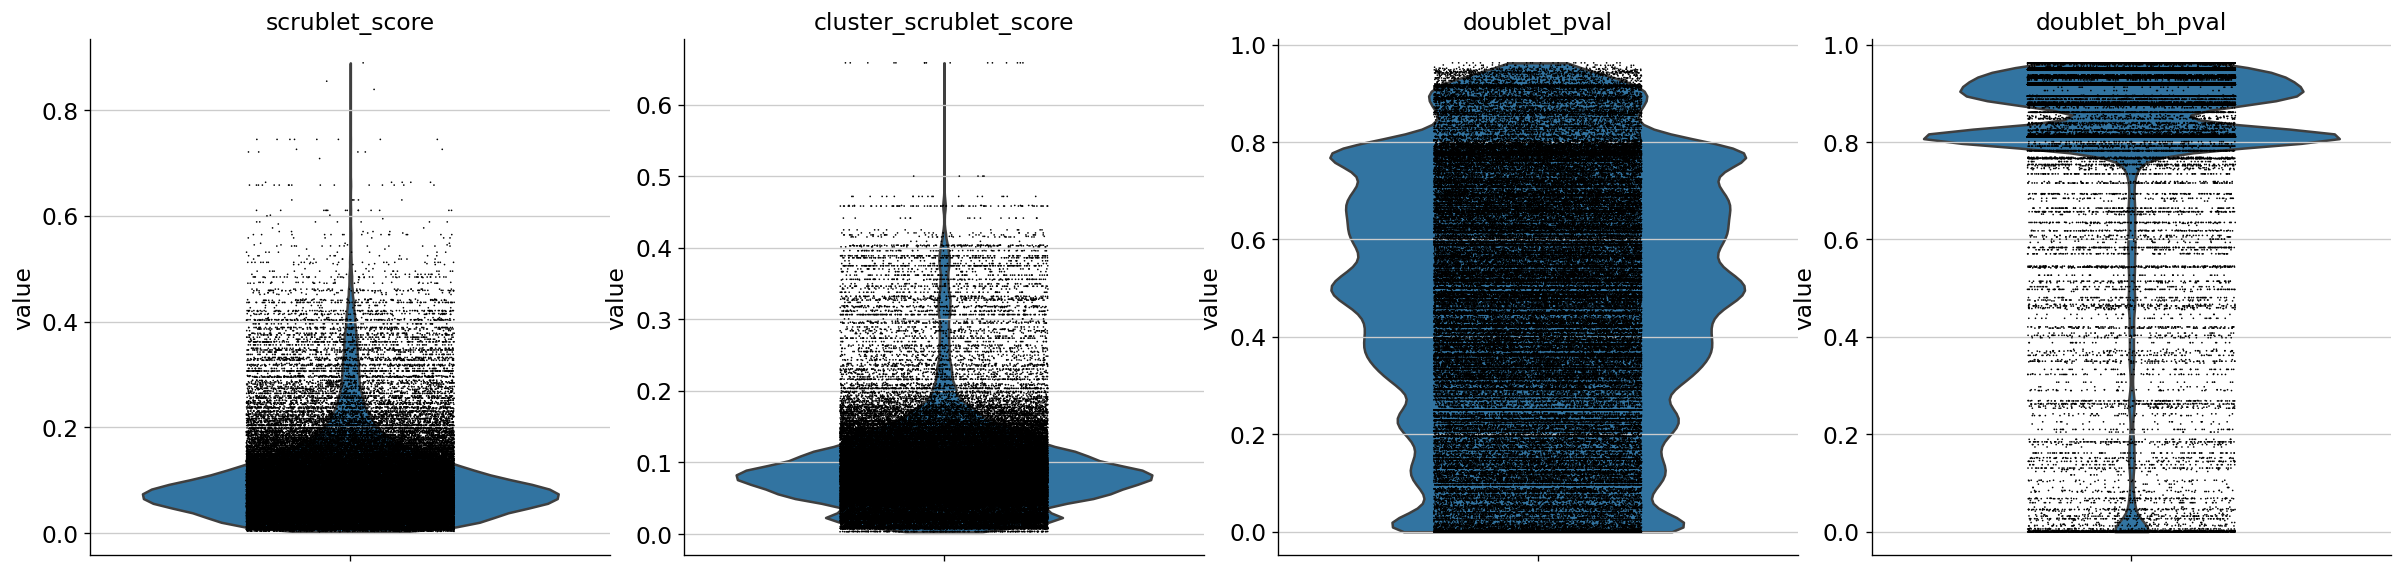

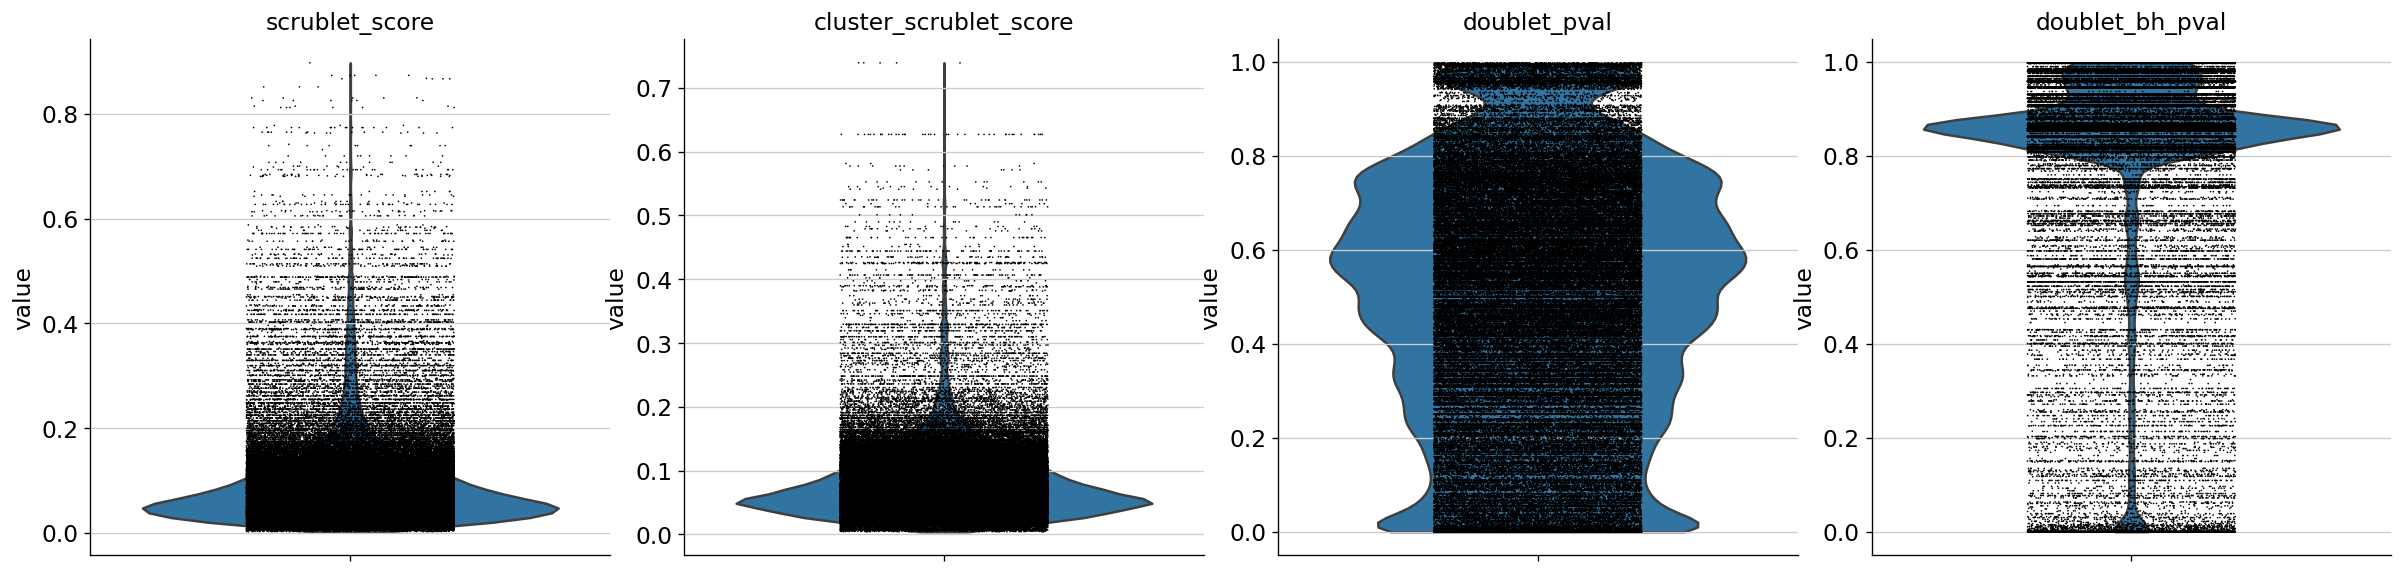

In [18]:
sc.pl.violin(adata[adata.obs['facility']=='Sanger'],
             ['scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'],jitter = 0.2, multi_panel = True)

sc.pl.violin(adata[adata.obs['facility']=='CSCI'],
             ['scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'],jitter = 0.2, multi_panel = True)

In [19]:
adata.obs['sangerID'].value_counts()

Sinha_F2             24275
Sinha_E2             24227
BHF_F_Hea11192328    21714
Sinha_E8             17219
BHF_F_Hea11192324    16688
BHF_F_Hea11192326    14117
BHF_F_Hea11192325    10676
Sinha_F4             10652
BHF_F_Hea11192327     9130
BHF_F_Hea10402918     8010
Sinha_F7              6973
Sinha_D8              6714
Sinha_A1              6640
Sinha_B1              5988
BHF_F_Hea11192323     4893
Sinha_C8              4587
BHF_F_Hea10402917     3752
Sinha_G4              3389
Sinha_F8              3203
Sinha_G7              2610
Name: sangerID, dtype: int64

## Uploading to Gdrive

In [ ]:
rclone copy /nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_foetal_prefilter.h5ad \
 gdrive:JamesC_Kazumasa/Foetal_Heart/SanjayShinha/toSinhalab/anndata/